## Overall Result comparison DBpedia translation
The purpose of this notebook is to compare and summarize the results achived by all the different models for DBpedia.

In [7]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm


C:\Users\malte\AppData\Local\Temp\ipykernel_30904\3238002101.py:66: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_for_plot = df_correctness.replace({True: 1, False: 0}).values


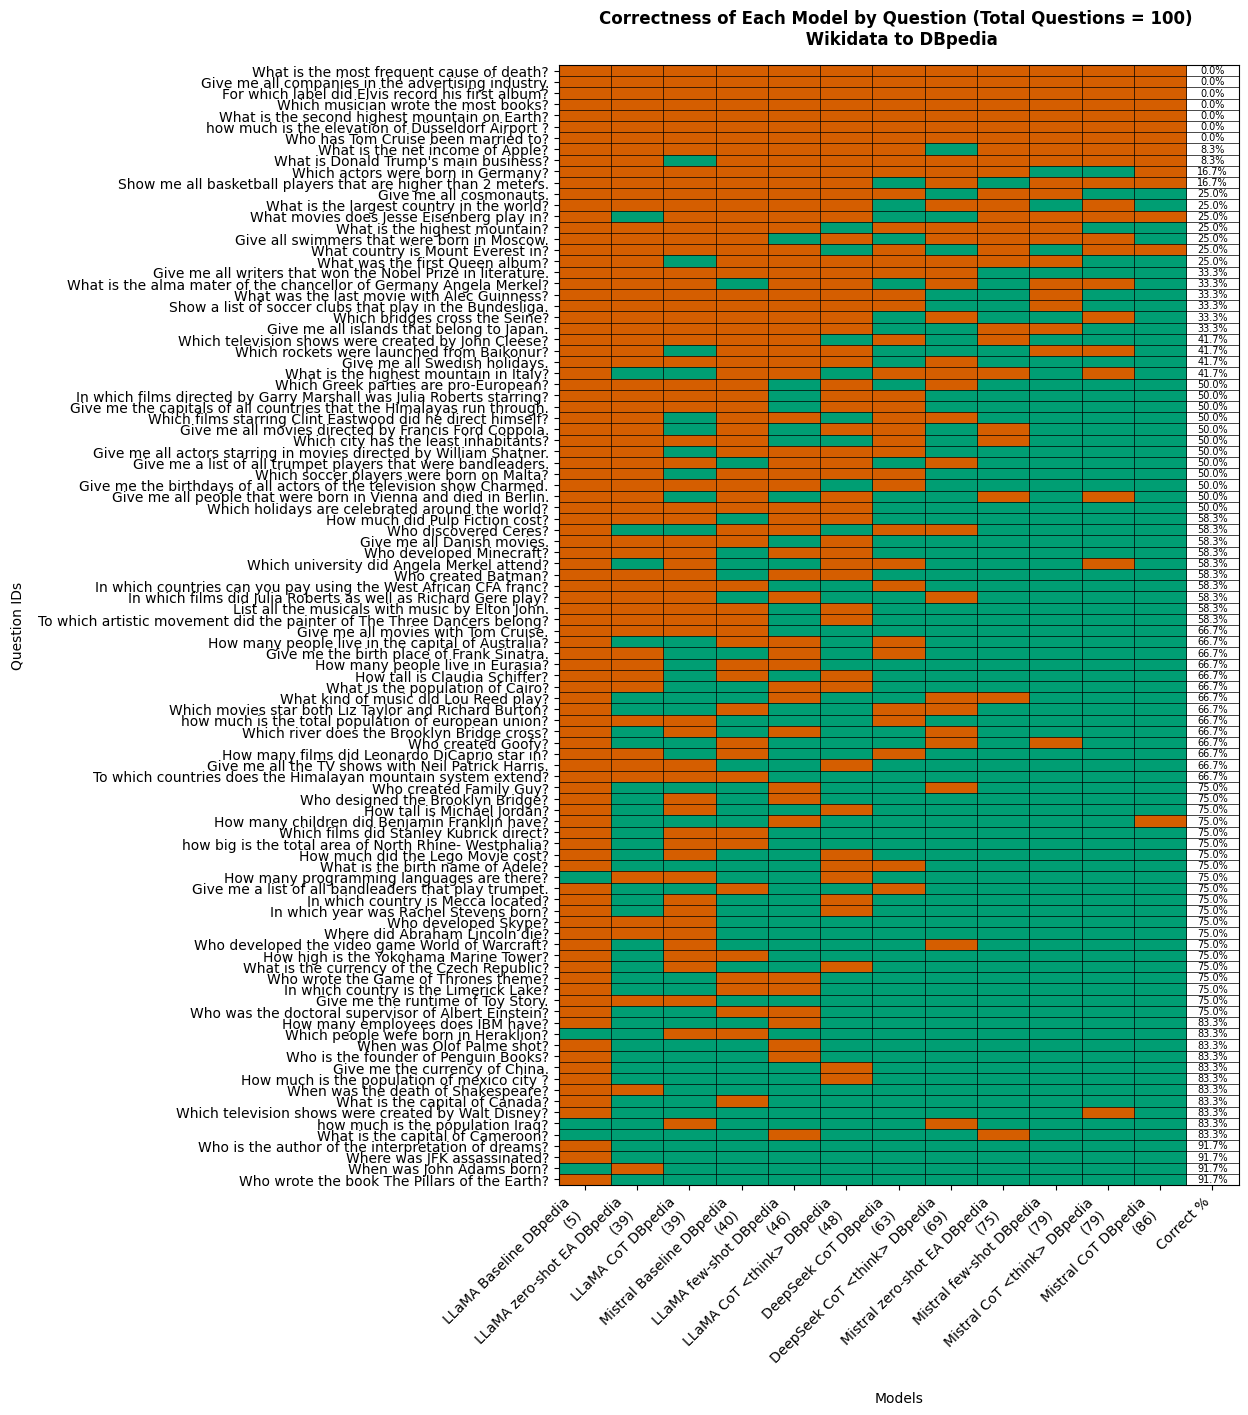

In [8]:
# ----------------------------
# 1. Define input file paths
# ----------------------------
solution_file_path = "../data/100_complete_entries_solution.json"

# List of (model_json_path, model_display_name)
model_files = [
    ("../QALD9-Plus-testing/baseline-model/baseline-wikidata-dbpedia/baseline_llama_wikidata_dbpedia_executed.json", "LLaMA Baseline DBpedia"),
    ("../QALD9-Plus-testing/zero-shot-entity-aligned/zero-shot-entity-aligned-wikidata-dbpedia/zero_shot_entity_aligned_llama_wikidata_dbpedia_executed.json", "LLaMA zero-shot EA DBpedia"),
    ("../QALD9-Plus-testing/baseline-model/baseline-wikidata-dbpedia/baseline_mistral_wikidata_dbpedia_executed.json", "Mistral Baseline DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia/CoT_llama_wikidata_dbpedia_executed.json", "LLaMA CoT DBpedia"),
    ("../QALD9-Plus-testing/few-shot-entity-aligned/few-shot-wikidata-dbpedia/few_shot_llama_wikidata_dbpedia_executed.json", "LLaMA few-shot DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia-think/CoT_llama_wikidata_dbpedia_executed_think.json", "LLaMA CoT <think> DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia-DeepSeek/CoT_deepseek_wikidata_dbpedia_executed.json", "DeepSeek CoT DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia-think/CoT_deepseek_wikidata_dbpedia_executed_think.json", "DeepSeek CoT <think> DBpedia"),
    ("../QALD9-Plus-testing/zero-shot-entity-aligned/zero-shot-entity-aligned-wikidata-dbpedia/zero_shot_entity_aligned_mistral_wikidata_dbpedia_executed.json", "Mistral zero-shot EA DBpedia"),
    ("../QALD9-Plus-testing/few-shot-entity-aligned/few-shot-wikidata-dbpedia/few_shot_mistral_wikidata_dbpedia_executed.json", "Mistral few-shot DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia-think/CoT_mistral_wikidata_dbpedia_executed_think.json", "Mistral CoT <think> DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia/CoT_mistral_wikidata_dbpedia_executed.json", "Mistral CoT DBpedia"),
]

# --------------------------------------------------
# 2. Load the gold solutions into a {question -> set_of_answers} mapping
# --------------------------------------------------
with open(solution_file_path, 'r', encoding='utf-8') as f:
    solution_data = json.load(f)

solution_mapping = {entry['question']: set(entry['dbpedia_results']) for entry in solution_data}

all_questions = list(solution_mapping.keys())

model_names = [m[1] for m in model_files]
df_correctness = pd.DataFrame(False, index=all_questions, columns=model_names)

# --------------------------------------------------
# 3. Fill correctness DataFrame (True/False)
# --------------------------------------------------
for model_file_path, model_name in model_files:
    with open(model_file_path, 'r', encoding='utf-8') as f:
        model_output = json.load(f)

    for record in model_output:
        question = record.get("natural_language_question", "")
        answers = record.get("answers", [])
        is_correct = answers not in [["Query failed"], ["No answer"]] and solution_mapping.get(question, set()) == set(answers)
        if question in df_correctness.index:
            df_correctness.loc[question, model_name] = is_correct

# --------------------------------------------------
# 4. Convert True/False to 1/0 for plotting and sort by Correct %
# --------------------------------------------------
num_models = len(model_names)
df_correctness["Correct %"] = (df_correctness.sum(axis=1) / num_models) * 100

# Sort by "Correct %" (ascending order: 0% on top, 100% at bottom)
df_correctness = df_correctness.sort_values(by="Correct %", ascending=True)

# Sort models (columns) based on total correct answers (ascending order)
correct_counts = df_correctness.iloc[:, :-1].sum().sort_values()
sorted_model_names = correct_counts.index.tolist()

# Reorder DataFrame columns
df_correctness = df_correctness[sorted_model_names + ["Correct %"]]

# Create data for heatmap
data_for_plot = df_correctness.replace({True: 1, False: 0}).values

# --------------------------------------------------
# 5. Plot heatmap
# --------------------------------------------------
n_questions = len(df_correctness.index)
fig, ax = plt.subplots(figsize=(10, 14))

cmap_main = mcolors.ListedColormap(["#D55E00", "#009E73"])
norm_main = mcolors.BoundaryNorm([-0.5, 0.5, 1.5], cmap_main.N)

im = ax.imshow(data_for_plot[:, :-1], cmap=cmap_main, norm=norm_main, aspect='auto')

ax.set_xticks(np.arange(len(sorted_model_names) + 1))
ax.set_yticks(np.arange(n_questions))

# Update x-axis labels with sorted models and correct answer counts
xtick_labels = [f"{name}\n({correct_counts[name]})" for name in sorted_model_names] + ["Correct %"]
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

ax.set_yticklabels(df_correctness.index)

ax.set_xticks(np.arange(len(sorted_model_names) + 2) - 0.5, minor=True)
ax.set_yticks(np.arange(n_questions + 1) - 0.5, minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

ax.set_title(f"Correctness of Each Model by Question (Total Questions = {n_questions}) \n Wikidata to DBpedia", fontweight='bold', pad=15)
ax.set_xlabel("Models", labelpad=10)
ax.set_ylabel("Question IDs", labelpad=10)

# --------------------------------------------------
# 6. Insert "Correct %" values inside the last column
# --------------------------------------------------
for i, perc_correct in enumerate(df_correctness["Correct %"]):
    ax.text(x=len(sorted_model_names), y=i, s=f"{perc_correct:.1f}%", va="center", ha="center", fontsize=7, color="black")

ax.set_xlim(-0.5, len(sorted_model_names) + 0.5)
plt.subplots_adjust(left=0.2, bottom=0.12, right=0.88, top=0.92)
plt.show()


C:\Users\malte\AppData\Local\Temp\ipykernel_30904\2396941063.py:66: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_correctness["Correct %"] = (df_correctness[model_columns].replace({True: 1, False: 0}).sum(axis=1) / len(model_columns)) * 100
C:\Users\malte\AppData\Local\Temp\ipykernel_30904\2396941063.py:99: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_for_plot = df_correctness[model_columns].replace({True: 1, False: 0}).values


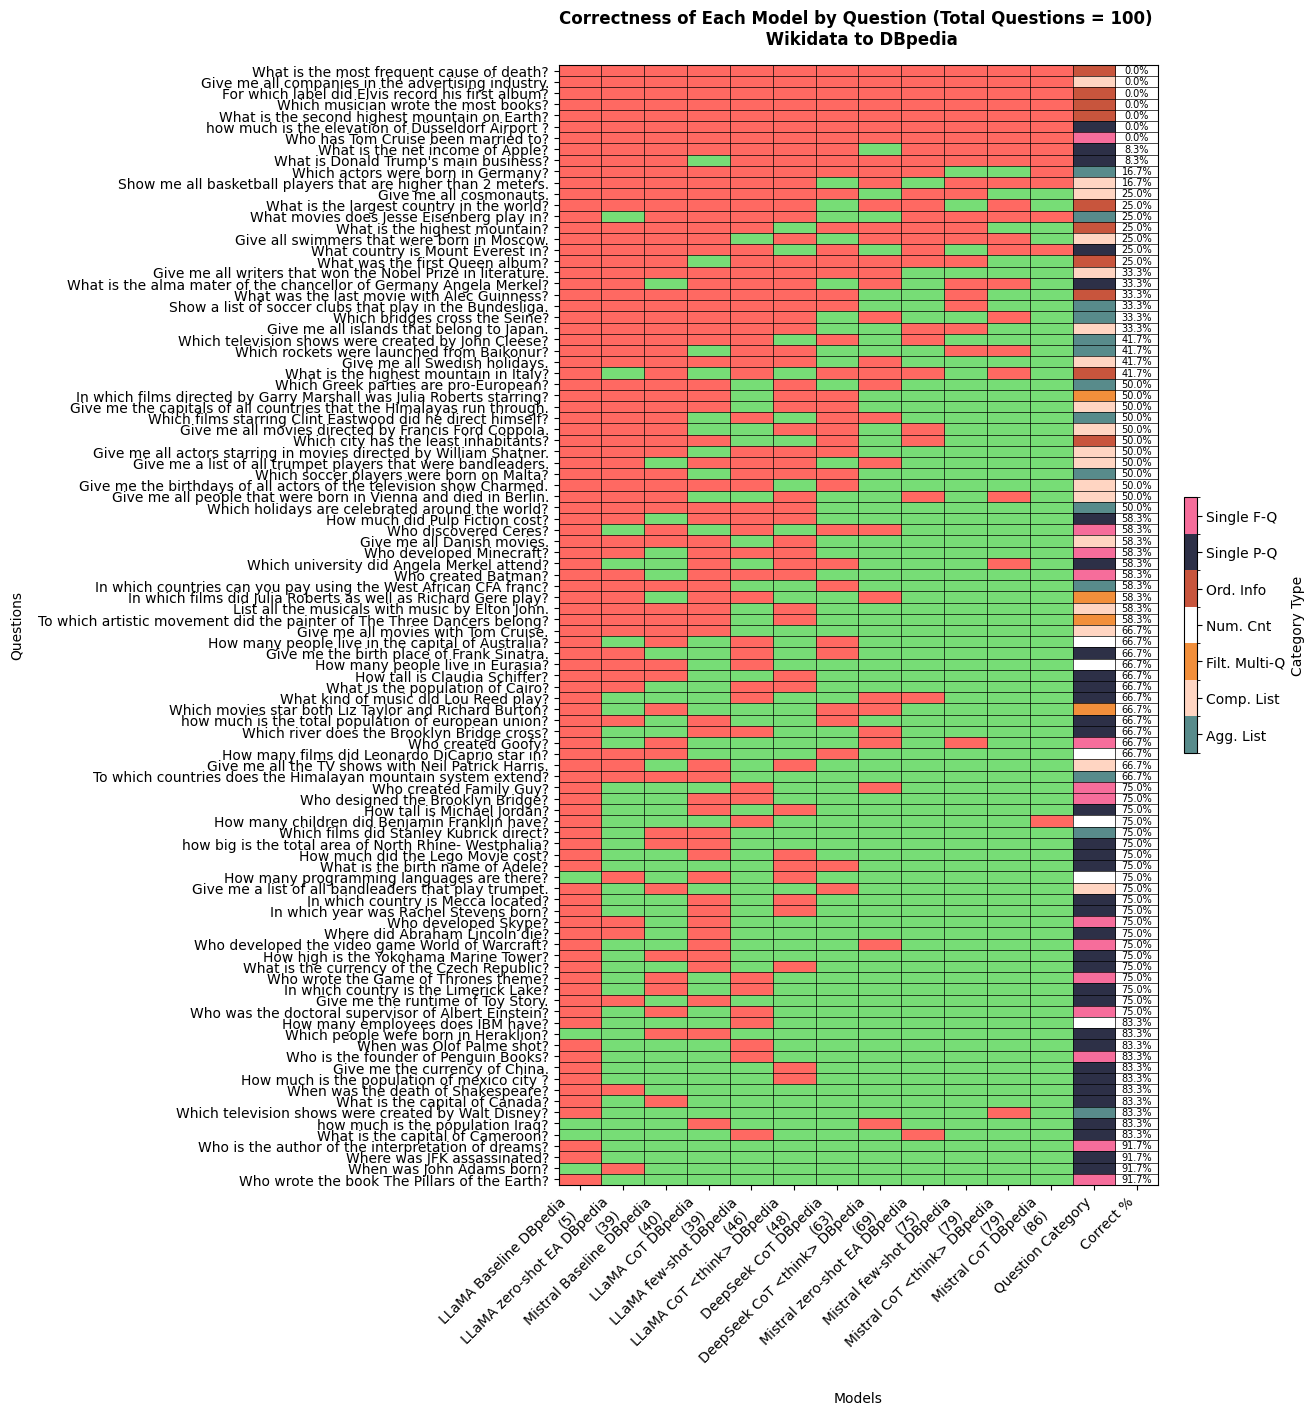

In [9]:
# ----------------------------
# 1. Define input file paths
# ----------------------------
solution_file_path = "../data/100_complete_entries_solution.json"

# List of (model_json_path, model_display_name)
model_files = [
    ("../QALD9-Plus-testing/baseline-model/baseline-wikidata-dbpedia/baseline_llama_wikidata_dbpedia_executed.json", "LLaMA Baseline DBpedia"),
    ("../QALD9-Plus-testing/zero-shot-entity-aligned/zero-shot-entity-aligned-wikidata-dbpedia/zero_shot_entity_aligned_llama_wikidata_dbpedia_executed.json", "LLaMA zero-shot EA DBpedia"),
    ("../QALD9-Plus-testing/baseline-model/baseline-wikidata-dbpedia/baseline_mistral_wikidata_dbpedia_executed.json", "Mistral Baseline DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia/CoT_llama_wikidata_dbpedia_executed.json", "LLaMA CoT DBpedia"),
    ("../QALD9-Plus-testing/few-shot-entity-aligned/few-shot-wikidata-dbpedia/few_shot_llama_wikidata_dbpedia_executed.json", "LLaMA few-shot DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia-think/CoT_llama_wikidata_dbpedia_executed_think.json", "LLaMA CoT <think> DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia-DeepSeek/CoT_deepseek_wikidata_dbpedia_executed.json", "DeepSeek CoT DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia-think/CoT_deepseek_wikidata_dbpedia_executed_think.json", "DeepSeek CoT <think> DBpedia"),
    ("../QALD9-Plus-testing/zero-shot-entity-aligned/zero-shot-entity-aligned-wikidata-dbpedia/zero_shot_entity_aligned_mistral_wikidata_dbpedia_executed.json", "Mistral zero-shot EA DBpedia"),
    ("../QALD9-Plus-testing/few-shot-entity-aligned/few-shot-wikidata-dbpedia/few_shot_mistral_wikidata_dbpedia_executed.json", "Mistral few-shot DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia-think/CoT_mistral_wikidata_dbpedia_executed_think.json", "Mistral CoT <think> DBpedia"),
    ("../QALD9-Plus-testing/CoT-entity-aligned/CoT-wikidata-dbpedia/CoT_mistral_wikidata_dbpedia_executed.json", "Mistral CoT DBpedia"),
]

# ----------------------------
# 2. Load solutions
# ----------------------------
with open(solution_file_path, 'r', encoding='utf-8') as f:
    solution_data = json.load(f)

solution_mapping = {entry['question']: set(entry['dbpedia_results']) for entry in solution_data}
all_questions = list(solution_mapping.keys())

# ----------------------------
# 3. Create correctness dataframe
# ----------------------------
model_names = [m[1] for m in model_files]
df_correctness = pd.DataFrame(False, index=all_questions, columns=model_names)

# ----------------------------
# 4. Fill correctness DataFrame
# ----------------------------
for model_file_path, model_name in model_files:
    with open(model_file_path, 'r', encoding='utf-8') as f:
        model_output = json.load(f)

    for record in model_output:
        question = record.get("natural_language_question", "")
        answers = record.get("answers", [])
        is_correct = answers not in [["Query failed"], ["No answer"]] and solution_mapping.get(question, set()) == set(answers)
        if question in df_correctness.index:
            df_correctness.loc[question, model_name] = is_correct

# ----------------------------
# 5. Load category mapping
# ----------------------------
file_path = "question_categories_py.xlsx"
xls = pd.ExcelFile(file_path)
df_correctness_mapping = pd.read_excel(xls, sheet_name="Correctness")
question_category_mapping = dict(zip(df_correctness_mapping["question"], df_correctness_mapping["category_number"]))

# ----------------------------
# 6. Add Category Column & Compute Correct %
# ----------------------------
df_correctness["Category"] = df_correctness.index.map(lambda q: question_category_mapping.get(q, np.nan))

# Calculate "Correct %" **excluding Category**
model_columns = [col for col in df_correctness.columns if col not in ["Category", "Correct %"]]
df_correctness["Correct %"] = (df_correctness[model_columns].replace({True: 1, False: 0}).sum(axis=1) / len(model_columns)) * 100

# ----------------------------
# 7. Sort Data
# ----------------------------

# Sort models (columns) based on total correct answers (ascending order)
correct_counts = df_correctness.iloc[:, :-1].sum().sort_values()
sorted_model_names = correct_counts.index.tolist()

df_correctness = df_correctness.sort_values(by="Correct %", ascending=True)
correct_counts = df_correctness[model_columns].sum().sort_values()
sorted_model_names = correct_counts.index.tolist()
df_correctness = df_correctness[sorted_model_names + ["Category", "Correct %"]]

# ----------------------------
# 8. Plot Heatmap
# ----------------------------

n_questions = len(df_correctness.index)
fig, ax = plt.subplots(figsize=(11, 14))

cmap_main = mcolors.ListedColormap(["#FF6962", "#77DD76"])
norm_main = mcolors.BoundaryNorm([-0.5, 0.5, 1.5], cmap_main.N)

# Define 7 distinct colors for category column
custom_colors = ["#588B8B", "#FFD5C2", "#F28F3B", "#FFFFFF", "#C8553D", "#2D3047", "#f66d9b"]
cmap_category = ListedColormap(custom_colors)

# Set category boundaries to prevent gradient
bounds = np.arange(0.5, 8.5, 1)  # 7 categories
norm_category = BoundaryNorm(bounds, cmap_category.N)

data_for_plot = df_correctness[model_columns].replace({True: 1, False: 0}).values
category_column = df_correctness["Category"].values.reshape(-1, 1)
category_color_data = np.hstack((np.full((n_questions, len(df_correctness.columns)-2), np.nan), category_column))

im = ax.imshow(data_for_plot, cmap=cmap_main, norm=norm_main, aspect='auto')
im_category = ax.imshow(category_color_data, cmap=cmap_category, norm=norm_category, aspect='auto')

xtick_labels = [f"{name}\n({df_correctness[name].sum()})" for name in model_columns] + ["Question Category", "Correct %"]
ax.set_xticks(np.arange(len(df_correctness.columns)))
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

ytick_labels = list(df_correctness.index)
ax.set_yticks(np.arange(n_questions))
ax.set_yticklabels(ytick_labels)

ax.set_xticks(np.arange(len(df_correctness.columns) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(n_questions + 1) - 0.5, minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

ax.set_title(f"Correctness of Each Model by Question (Total Questions = {n_questions}) \n Wikidata to DBpedia", fontweight='bold', pad=15)
ax.set_xlabel("Models", labelpad=10)
ax.set_ylabel("Questions", labelpad=10)

for i, perc_correct in enumerate(df_correctness["Correct %"]):
    ax.text(x=len(df_correctness.columns) - 1, y=i, s=f"{perc_correct:.1f}%", va="center", ha="center", fontsize=7, color="black")

category_labels = ["Agg. List", "Comp. List", "Filt. Multi-Q", "Num. Cnt", "Ord. Info", "Single P-Q", "Single F-Q"]

cbar = plt.colorbar(im_category, ax=ax, ticks=np.arange(1, 8), fraction=0.02, pad=0.04)
cbar.set_label("Category Type")
cbar.ax.set_yticklabels(category_labels)

ax.set_xlim(-0.5, len(df_correctness.columns) - 0.5)
plt.subplots_adjust(left=0.3, bottom=0.12, right=0.88, top=0.92)
plt.show()

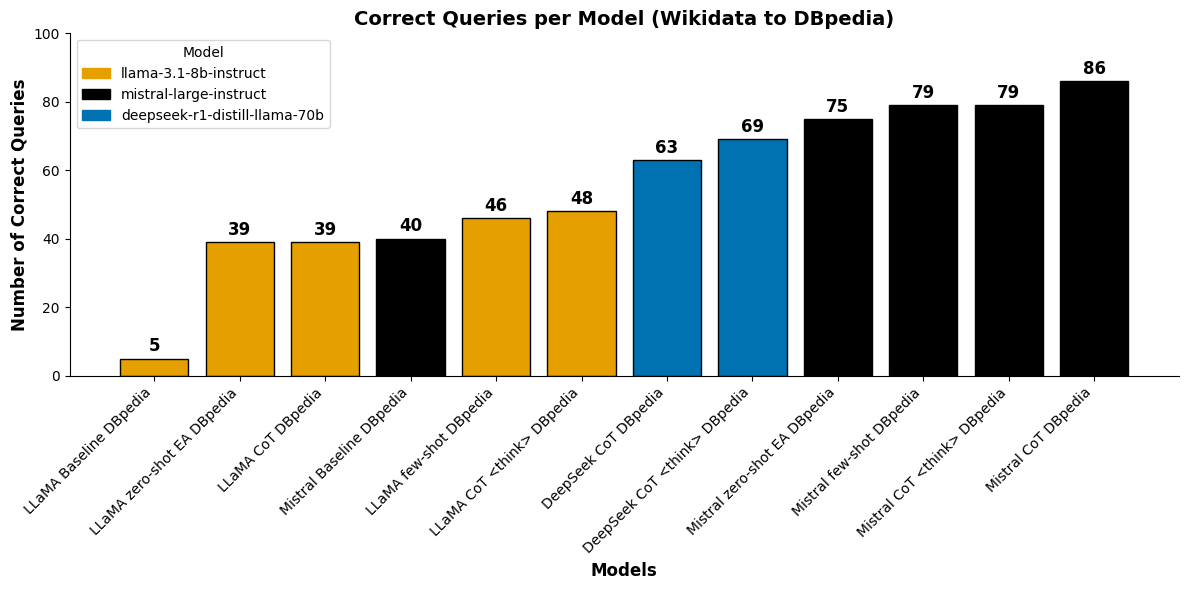

In [10]:
# Extract the number of correct answers per model
correct_counts = df_correctness[model_columns].sum().sort_values(ascending=True)

# Define colors for different model groups
color_mapping = {
    "llama": "#E69F00",
    "mistral": "#000000",
    "deepseek": "#0072B2",
}

# Assign colors based on model names
bar_colors = []
for model in correct_counts.index:
    if "llama" in model.lower():
        bar_colors.append(color_mapping["llama"])
    elif "mistral" in model.lower():
        bar_colors.append(color_mapping["mistral"])
    elif "deepseek" in model.lower():
        bar_colors.append(color_mapping["deepseek"])
    else:
        bar_colors.append("gray")  # Default color for unknown models

# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(correct_counts.index, correct_counts.values, color=bar_colors, edgecolor="black")

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(int(height)),
            ha='center', va='bottom', fontsize=12, fontweight="bold")

# Set y-axis limit to 100
ax.set_ylim(0, 100)

# Labeling
ax.set_xlabel("Models", fontsize=12, fontweight="bold")
ax.set_ylabel("Number of Correct Queries", fontsize=12, fontweight="bold")
ax.set_title("Correct Queries per Model (Wikidata to DBpedia)", fontsize=14, fontweight="bold")

# Format x-ticks
ax.set_xticks(np.arange(len(correct_counts.index)))
ax.set_xticklabels(correct_counts.index, rotation=45, ha="right", fontsize=10)

# Grid lines for readability
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add a legend with updated labels and correct colors
legend_labels = ["llama-3.1-8b-instruct", "mistral-large-instruct", "deepseek-r1-distill-llama-70b"]
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[key]) for key in color_mapping]
ax.legend(legend_patches, legend_labels, loc="upper left", title="Model", fontsize=10)

# Display the chart
plt.tight_layout()
plt.show()
